<a href="https://colab.research.google.com/github/chan-kh/Music-Sentiment-Analysis/blob/main/LSTM_2outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import os
import datetime
from google.colab import drive

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Bidirectional

from math import sqrt
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [32]:
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sentiment/features_60frames_allsongs.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,song_id,frame_num,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,valence,arousal
0,2,0,0.157715,0.000011,5604.262879,3246.069688,9549.975586,18.349374,0.283305,0.000000,-636.134705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654255,0.699066,0.261531,0.874848,1.000000,0.333313,0.812421,0.488101,0.413135,0.640419,0.671442,0.490904,0.725918,0.250459,0.284098,0.647150,0.349017,0.147453,0.501239,0.074669,0.070883,0.633342,0.184297,0.136420,0.700169,0.030602,0.209675,0.828279,0.124886,0.257948,1.000000,0.071105,0.309559,0.798000,0.076693,0.276441,-0.134078,0.072852,-0.134683,0.086125,0.060471,0.042898,-0.073341,-0.109386
1,2,1,0.051758,0.096817,1443.667160,2057.611806,3036.181641,27.017306,0.003931,1.576688,-120.319748,129.464996,-4.253306,22.214062,8.163963,16.415987,15.152133,7.878392,-6.823561,-0.831550,-7.218902,-4.558928,-1.807601,12.948887,-9.162554,-3.758020,-5.506585,-1.227700,-4.439484,1.684063,0.528904,0.624552,0.263783,0.891966,0.850903,0.331133,1.000000,1.000000,0.408033,0.713866,0.681263,0.480444,0.245905,0.378263,0.278916,0.160639,0.397115,0.147040,0.285743,0.536704,0.072041,0.314144,0.652729,0.144099,0.269362,0.637670,0.218737,0.382769,0.677961,0.263132,0.424450,0.649488,0.317883,0.517798,0.579528,0.282752,-0.088692,0.052331,-0.112961,0.075804,0.041915,0.033029,-0.074661,-0.114942
2,2,2,0.101562,0.096426,2348.097128,2387.006355,4941.870117,22.434103,0.013857,0.152583,-107.915352,76.319107,-14.175928,45.124214,1.209538,7.516734,-5.023264,6.480774,-0.513962,8.108901,-0.198636,-3.022716,2.078595,4.819644,-16.200150,-3.348299,-5.746615,-9.680576,-17.688511,-5.846364,0.190785,0.290683,0.265836,0.206553,0.217986,0.329024,0.491271,0.576434,0.402986,1.000000,0.924618,0.469653,0.706139,0.605435,0.273279,0.307669,0.224213,0.146400,0.107266,0.206321,0.073380,0.222554,0.297425,0.151825,0.408395,0.409732,0.227828,0.563377,0.734764,0.268284,0.755202,1.000000,0.326054,0.528056,0.687259,0.288720,-0.034494,0.031843,-0.070020,0.068549,0.021691,0.023202,-0.074077,-0.116413
3,2,3,0.062500,0.086847,1692.187106,1872.280637,3219.213867,21.295763,0.004178,0.224268,-148.255432,121.565720,-36.703545,33.151939,4.518500,5.197342,-8.610166,4.267920,8.706326,-17.273952,-11.429454,4.515498,-7.324573,4.467141,-13.720921,-3.195490,-3.931114,-7.317858,-15.654930,-15.824336,0.245845,0.300974,0.267710,0.523842,0.578168,0.326966,1.000000,0.842026,0.397746,0.846539,1.000000,0.458391,0.477668,0.673670,0.267148,0.095004,0.189054,0.145584,0.031817,0.101448,0.075003,0.024125,0.114284,0.159790,0.044276,0.137589,0.237066,0.215029,0.300263,0.273559,0.177739,0.341496,0.334054,0.110806,0.207098,0.294537,-0.013095,0.020309,-0.055259,0.034349,0.011610,0.012032,-0.078154,-0.118613
4,2,4,0.120605,0.113167,2632.895857,2453.043616,5329.467773,18.914987,0.025196,1.035493,-71.919838,76.267471,-28.003765,15.988888,4.667567,35.548042,-6.664427,-5.128408,9.827440,-1.635414,-5.240368,-1.569069,-1.458279,7.581460,-16.175152,-6.295955,-9.435411,-3.781498,-8.782184,-7.635081,0.223808,0.355715,0.269517,0.202841,0.376315,0.324933,0.624933,0.684395,0.392219,1.000000,1.000000,0.446547,0.319092,0.

In [33]:
df.shape

(104640, 74)

In [34]:
df.pop('song_id')
df.pop('frame_num')

0          0
1          1
2          2
3          3
4          4
          ..
104635    55
104636    56
104637    57
104638    58
104639    59
Name: frame_num, Length: 104640, dtype: int64

In [35]:
y = df.loc[:,'valence':'arousal']
print(y.shape)
y.head()

(104640, 2)


,valence,arousal
0,-0.073341,-0.109386
1,-0.074661,-0.114942
2,-0.074077,-0.116413
3,-0.078154,-0.118613
4,-0.081588,-0.126457


In [36]:
df.pop('valence')
df.pop('arousal')

0        -0.109386
1        -0.114942
2        -0.116413
3        -0.118613
4        -0.126457
            ...   
104635    0.517000
104636    0.481000
104637    0.487000
104638    0.490000
104639    0.478000
Name: arousal, Length: 104640, dtype: float64

In [37]:
df.head()


,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5
0,0.157715,0.000011,5604.262879,3246.069688,9549.975586,18.349374,0.283305,0.000000,-636.134705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654255,0.699066,0.261531,0.874848,1.000000,0.333313,0.812421,0.488101,0.413135,0.640419,0.671442,0.490904,0.725918,0.250459,0.284098,0.647150,0.349017,0.147453,0.501239,0.074669,0.070883,0.633342,0.184297,0.136420,0.700169,0.030602,0.209675,0.828279,0.124886,0.257948,1.000000,0.071105,0.309559,0.798000,0.076693,0.276441,-0.134078,0.072852,-0.134683,0.086125,0.060471,0.042898
1,0.051758,0.096817,1443.667160,2057.611806,3036.181641,27.017306,0.003931,1.576688,-120.319748,129.464996,-4.253306,22.214062,8.163963,16.415987,15.152133,7.878392,-6.823561,-0.831550,-7.218902,-4.558928,-1.807601,12.948887,-9.162554,-3.758020,-5.506585,-1.227700,-4.439484,1.684063,0.528904,0.624552,0.263783,0.891966,0.850903,0.331133,1.000000,1.000000,0.408033,0.713866,0.681263,0.480444,0.245905,0.378263,0.278916,0.160639,0.397115,0.147040,0.285743,0.536704,0.072041,0.314144,0.652729,0.144099,0.269362,0.637670,0.218737,0.382769,0.677961,0.263132,0.424450,0.649488,0.317883,0.517798,0.579528,0.282752,-0.088692,0.052331,-0.112961,0.075804,0.041915,0.033029
2,0.101562,0.096426,2348.097128,2387.006355,4941.870117,22.434103,0.013857,0.152583,-107.915352,76.319107,-14.175928,45.124214,1.209538,7.516734,-5.023264,6.480774,-0.513962,8.108901,-0.198636,-3.022716,2.078595,4.819644,-16.200150,-3.348299,-5.746615,-9.680576,-17.688511,-5.846364,0.190785,0.290683,0.265836,0.206553,0.217986,0.329024,0.491271,0.576434,0.402986,1.000000,0.924618,0.469653,0.706139,0.605435,0.273279,0.307669,0.224213,0.146400,0.107266,0.206321,0.073380,0.222554,0.297425,0.151825,0.408395,0.409732,0.227828,0.563377,0.734764,0.268284,0.755202,1.000000,0.326054,0.528056,0.687259,0.288720,-0.034494,0.031843,-0.070020,0.068549,0.021691,0.023202
3,0.062500,0.086847,1692.187106,1872.280637,3219.213867,21.295763,0.004178,0.224268,-148.255432,121.565720,-36.703545,33.151939,4.518500,5.197342,-8.610166,4.267920,8.706326,-17.273952,-11.429454,4.515498,-7.324573,4.467141,-13.720921,-3.195490,-3.931114,-7.317858,-15.654930,-15.824336,0.245845,0.300974,0.267710,0.523842,0.578168,0.326966,1.000000,0.842026,0.397746,0.846539,1.000000,0.458391,0.477668,0.673670,0.267148,0.095004,0.189054,0.145584,0.031817,0.101448,0.075003,0.024125,0.114284,0.159790,0.044276,0.137589,0.237066,0.215029,0.300263,0.273559,0.177739,0.341496,0.334054,0.110806,0.207098,0.294537,-0.013095,0.020309,-0.055259,0.034349,0.011610,0.012032
4,0.120605,0.113167,2632.895857,2453.043616,5329.467773,18.914987,0.025196,1.035493,-71.919838,76.267471,-28.003765,15.988888,4.667567,35.548042,-6.664427,-5.128408,9.827440,-1.635414,-5.240368,-1.569069,-1.458279,7.581460,-16.175152,-6.295955,-9.435411,-3.781498,-8.782184,-7.635081,0.223808,0.355715,0.269517,0.202841,0.376315,0.324933,0.624933,0.684395,0.392219,1.000000,1.000000,0.446547,0.319092,0.448243,0.260494,0.103011,0.139945,0.144729,0.191945,0.245747,0.076884,0.266807,0.286048,0.167931,0.120557,0.326037,0.246430,0.267567,0

In [38]:
# df_mean = df.mean()
# df_std = df.std()

# df = (df - df_mean) / df_std


In [39]:
# print(type(df))

In [40]:
features = df.to_numpy()
y = y.to_numpy()

In [41]:
print(features.shape)
print(y.shape)

(104640, 70)
(104640, 2)


In [42]:
features = features.reshape(1744,60,70)
y = y.reshape(1744,60,2)

In [43]:
train_X , train_y = features[0:1220] , y[0:1220]
test_X , test_y = features[1220:1744] , y[1220:1744]
# val_X , val_y = features [1569:1744] , valence[0:1220]

In [44]:
print("train_X :" , train_X.shape , "train_y shape:" , train_y.shape)
print("test_X :" , test_X.shape , "test_y shape:" , test_y.shape)
# print("val_X :" , val_X.shape , "val_y shape:" , val_y.shape)


train_X : (1220, 60, 70) train_y shape: (1220, 60, 2)
test_X : (524, 60, 70) test_y shape: (524, 60, 2)


In [45]:
# print(features.shape)
# for i in range(1):
#   print(features)

In [46]:
# print(valence.shape)
# print(valence)

In [47]:
# print(type(features))
# print(features.shape)

In [48]:
model = Sequential()

# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(60,70))))
model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(32,return_sequences=True, input_shape=(60,70))))
# model.add(Bidirectional(LSTM(16,return_sequences=True, input_shape=(60,70))))
# model.add(Bidirectional(LSTM(8,return_sequences=True, input_shape=(60,70))))




model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')

In [49]:
history = model.fit(train_X, train_y, epochs=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/500
39/39 - 3s - loss: 0.1234 - val_loss: 0.0335
Epoch 2/500
39/39 - 1s - loss: 0.0606 - val_loss: 0.0314
Epoch 3/500
39/39 - 1s - loss: 0.0580 - val_loss: 0.0342
Epoch 4/500
39/39 - 1s - loss: 0.0592 - val_loss: 0.0377
Epoch 5/500
39/39 - 1s - loss: 0.0540 - val_loss: 0.0379
Epoch 6/500
39/39 - 1s - loss: 0.0517 - val_loss: 0.0374
Epoch 7/500
39/39 - 1s - loss: 0.0505 - val_loss: 0.0352
Epoch 8/500
39/39 - 1s - loss: 0.0500 - val_loss: 0.0325
Epoch 9/500
39/39 - 1s - loss: 0.0503 - val_loss: 0.0312
Epoch 10/500
39/39 - 1s - loss: 0.0498 - val_loss: 0.0316
Epoch 11/500
39/39 - 1s - loss: 0.0495 - val_loss: 0.0315
Epoch 12/500
39/39 - 1s - loss: 0.0491 - val_loss: 0.0315
Epoch 13/500
39/39 - 1s - loss: 0.0497 - val_loss: 0.0319
Epoch 14/500
39/39 - 1s - loss: 0.0501 - val_loss: 0.0320
Epoch 15/500
39/39 - 1s - loss: 0.0495 - val_loss: 0.0317
Epoch 16/500
39/39 - 1s - loss: 0.0489 - val_loss: 0.0314
Epoch 17/500
39/39 - 1s - loss: 0.0488 - val_loss: 0.0315
Epoch 18/500
39/39 - 1s

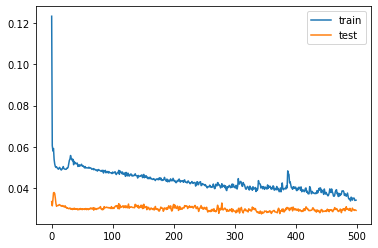

<Figure size 432x288 with 0 Axes>

In [50]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.savefig("training loss 350epochs_5layers")

In [51]:
history.history
print('overall loss' , np.mean(history.history['loss']))
print('overall val_loss' , np.mean(history.history['val_loss']))

overall loss 0.043347365476191044
overall val_loss 0.029942402616143227


In [52]:
predicted_y = model.predict(test_X)


In [53]:
print(predicted_y.shape)
print(test_y.shape)

(524, 60, 2)
(524, 60, 2)


In [54]:
predicted_valence = predicted_y[:,:,0]
predicted_arousal = predicted_y[:,:,1]
test_valence = test_y[:,:,0]
test_arousal = test_y[:,:,1]

In [55]:
# for i in range(1):
  # print(predicted_valence[i])
  # print(predicted_arousal[i])
  # print(test_valence[i])
  # print(test_arousal[i])

In [56]:
predicted_valence = predicted_valence.reshape(31440,)
test_valence = test_valence.reshape(31440,)
predicted_arousal = predicted_arousal.reshape(31440,)
test_arousal = test_arousal.reshape(31440,)

In [57]:
def metrics(y_true,y_pred,name):
  print(name,"")
  mae = mean_absolute_error(y_true,y_pred)
  rmse = sqrt(mean_squared_error(y_true,y_pred))
  r2 = r2_score(y_true,y_pred)
  pearson_corr = pearsonr(y_true,y_pred)
  spearman_corr = spearmanr(y_true,y_pred)
  
  print('Pearson : ',pearson_corr)
  print('RMSE : ',rmse)
  print('MAE : ',mae)
  print('R2 : ',r2)
  print('Spearman : ',spearman_corr,'\n')


In [58]:
def graph_results(x,y,title, xlim=-1, ylim=-1):
  #x and y are variables ( y_pred vs y_true )
  #Important
  plt.scatter(x,y,s=15)

  # if xlim != -1: plt.xlim([0, xlim])
  # if ylim != -1: plt.ylim([0, ylim])
  # plt.gca().set_ylim([1.5,7.5])
  # plt.gca().set_xlim([1.5,9])
  #Fix 
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title((title))
  # m, b = np.polyfit(x, y, 1)
  # plt.plot(x, m*x + b, color='red')  
  plt.savefig(title)

  plt.show()

valence 
Pearson :  (0.397346064441529, 0.0)
RMSE :  0.19082587021899178
MAE :  0.15069161532460448
R2 :  0.0928879649710248
Spearman :  SpearmanrResult(correlation=0.386523507483442, pvalue=0.0) 



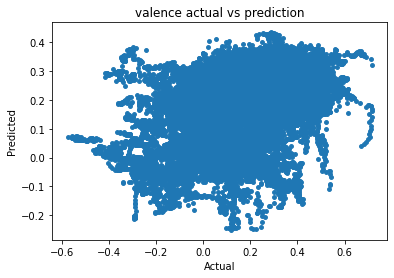

In [59]:
metrics(test_valence,predicted_valence,'valence')
graph_results(test_valence,predicted_valence,'valence actual vs prediction')


arousal 
Pearson :  (0.746643482857607, 0.0)
RMSE :  0.14828268873658706
MAE :  0.11723663092707622
R2 :  0.529372399339681
Spearman :  SpearmanrResult(correlation=0.7380083799535985, pvalue=0.0) 



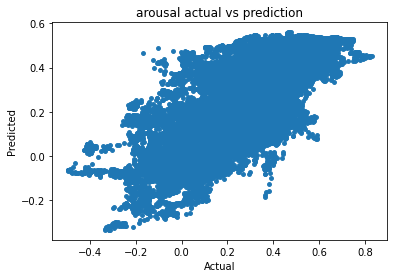

In [60]:
metrics(test_arousal,predicted_arousal,'arousal')
graph_results(test_arousal,predicted_arousal,'arousal actual vs prediction')